In [3]:
import torch
import torch.cuda
import numpy as np

In [4]:
# setting device on GPU if available, else CPU
device =  torch.device('cpu') 
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



In [5]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import random
#seed_everything(random.randint(1, 10000))

In [6]:
import torchtext.datasets

train_iter, test_iter  = torchtext.datasets.AG_NEWS()

In [7]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_iter]), min_freq=3, specials=["<UNK>"])
#vocab = build_vocab_from_iterator(build_vocabulary([train_iter, test_iter]), min_freq=10, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])
len(vocab)

40708

In [8]:
def save_vocab(vocab):
    import pickle
    output = open('vocab.pkl', 'wb')
    pickle.dump(vocab, output)
    output.close()

save_vocab(vocab)

In [9]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

train_dataset, test_dataset  = to_map_style_dataset(train_iter), to_map_style_dataset(test_iter)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

max_words = 50

In [10]:
train_dataset[3]

(3,
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.')

In [11]:
train_dataset[10000]

(1,
 'A Daily Look at U.S. Iraq Military Deaths (AP) AP - As of Wednesday, Aug. 25, 964 U.S. service members have died since the beginning of military operations in Iraq in March 2003, according to the Defense Department. Of those, 722 died as a result of hostile action and 242 died of non-hostile causes.')

In [21]:
def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] 

    return torch.tensor(X, dtype=torch.int32).to(device), (torch.tensor(Y) - 1).to(device) 

batch_size = 512 
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, collate_fn=vectorize_batch)

In [22]:
train_dataset

<torchtext.data.functional.to_map_style_dataset.<locals>._MapStyleDataset at 0x2153bd01c10>

In [23]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torch import flatten

In [25]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Test Loss  : {:.3f}".format(torch.tensor(losses).mean()))
        print("Test Acc   : {:.3f}\n".format(accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())))

def train_model(model, loss_fn, optimizer, train_loader, test_loader, epochs=10, test=False):
    for i in range(1, epochs + 1):
        losses = []
        #for X, Y in tqdm(train_loader):
        for X, Y in train_loader:
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        if test:
            CalcValLossAndAccuracy(model, loss_fn, test_loader)

def make_predictions(model, loader):
    Y_shuffled, Y_preds = [], []
    with torch.no_grad():
        for X, Y in loader:
            preds = model(X)
            Y_preds.append(preds)
            Y_shuffled.append(Y)
        gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

def print_results(Y_actual, Y_preds, target_names):
    print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
    print("\nClassification Report : ")
    print(classification_report(Y_actual, Y_preds, target_names=target_classes))
    print("\nConfusion Matrix : ")

    from sklearn.metrics import confusion_matrix
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    import numpy as np

    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        )
    plt.xticks(rotation=90)

def save_model(model, name):
    path = './net_'+ name +'.pth'
    print(path)
    torch.save(model.state_dict(), path)

In [30]:
embed_len = max_words
hidden_size = 50

class LSTM_1(nn.Module):
    def __init__(self):
        super(LSTM_1, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(max_words, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, len(target_classes))
        
    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        lstm_out, _ = self.lstm(embeddings)
        output = self.fc(lstm_out[:, -1])
        return output

In [46]:
from torch.optim import Adam
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
LSTM_classifier =LSTM_1().to(device)
optimizer = Adam(LSTM_classifier.parameters(), lr=learning_rate)

train_model(LSTM_classifier, loss_fn, optimizer, train_loader, test_loader, epochs, test=True)
save_model(LSTM_classifier, 'lstm_simple')
gc.collect()
torch.cuda.empty_cache()

Train Loss : 1.221
Test Loss  : 0.841
Test Acc   : 0.660

Train Loss : 0.606
Test Loss  : 0.496
Test Acc   : 0.825

Train Loss : 0.404
Test Loss  : 0.395
Test Acc   : 0.866

Train Loss : 0.323
Test Loss  : 0.357
Test Acc   : 0.878

Train Loss : 0.279
Test Loss  : 0.326
Test Acc   : 0.892

Train Loss : 0.246
Test Loss  : 0.319
Test Acc   : 0.895

Train Loss : 0.221
Test Loss  : 0.317
Test Acc   : 0.899

Train Loss : 0.197
Test Loss  : 0.312
Test Acc   : 0.899

Train Loss : 0.181
Test Loss  : 0.321
Test Acc   : 0.899

Train Loss : 0.164
Test Loss  : 0.316
Test Acc   : 0.901

Train Loss : 0.150
Test Loss  : 0.332
Test Acc   : 0.901

Train Loss : 0.136
Test Loss  : 0.328
Test Acc   : 0.903

Train Loss : 0.124
Test Loss  : 0.343
Test Acc   : 0.902

Train Loss : 0.113
Test Loss  : 0.347
Test Acc   : 0.902

Train Loss : 0.103
Test Loss  : 0.355
Test Acc   : 0.899

./net_lstm_simple.pth


Test Accuracy : 0.8989473684210526

Classification Report : 
              precision    recall  f1-score   support

       World       0.93      0.89      0.91      1900
      Sports       0.95      0.96      0.96      1900
    Business       0.86      0.86      0.86      1900
    Sci/Tech       0.85      0.89      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600


Confusion Matrix : 


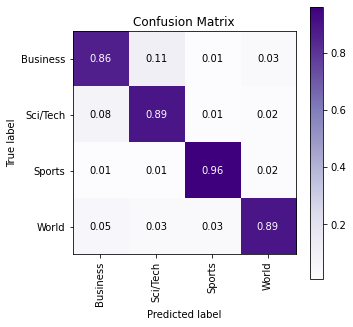

In [47]:
Y_actual, Y_preds = make_predictions(LSTM_classifier, test_loader)
print_results(Y_actual, Y_preds, target_classes)

In [40]:
embed_len = max_words
hidden_size = 50
num_layers = 3

class LSTM_2(nn.Module):
    def __init__(self):
        super(LSTM_2, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm_layers = []
        self.lstm_layers.append(nn.LSTM(max_words, hidden_size, batch_first=True))
        for i in range(num_layers - 1):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))
        
        self.fc = nn.Linear(hidden_size, len(target_classes))
        
    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        lstm_out, _ = self.lstm_layers[0](embeddings)
        for i in range(1, num_layers):
            # Получение выходных значений и скрытого состояния текущего слоя
            lstm_out, _ = self.lstm_layers[i](lstm_out)
            # Добавление скрытого состояния в список
        
        output = self.fc(lstm_out[:, -1])
        return output

In [41]:
from torch.optim import Adam
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
LSTM_classifier_layers = LSTM_2().to(device)
optimizer = Adam(LSTM_classifier_layers.parameters(), lr=learning_rate)

train_model(LSTM_classifier_layers, loss_fn, optimizer, train_loader, test_loader, epochs, test=True)
save_model(LSTM_classifier_layers, 'lstm_layers')
gc.collect()
torch.cuda.empty_cache()

Train Loss : 1.386
Test Loss  : 1.384
Test Acc   : 0.293

Train Loss : 1.381
Test Loss  : 1.377
Test Acc   : 0.293

Train Loss : 1.373
Test Loss  : 1.369
Test Acc   : 0.303

Train Loss : 1.361
Test Loss  : 1.355
Test Acc   : 0.342

Train Loss : 1.341
Test Loss  : 1.331
Test Acc   : 0.403

Train Loss : 1.306
Test Loss  : 1.289
Test Acc   : 0.451

Train Loss : 1.252
Test Loss  : 1.236
Test Acc   : 0.521

Train Loss : 1.193
Test Loss  : 1.182
Test Acc   : 0.554

Train Loss : 1.135
Test Loss  : 1.131
Test Acc   : 0.574

Train Loss : 1.081
Test Loss  : 1.084
Test Acc   : 0.593

Train Loss : 1.029
Test Loss  : 1.038
Test Acc   : 0.611

Train Loss : 0.979
Test Loss  : 0.992
Test Acc   : 0.632

Train Loss : 0.925
Test Loss  : 0.942
Test Acc   : 0.666

Train Loss : 0.869
Test Loss  : 0.893
Test Acc   : 0.692

Train Loss : 0.817
Test Loss  : 0.849
Test Acc   : 0.703

./net_lstm_simple.pth


Test Accuracy : 0.7027631578947369

Classification Report : 
              precision    recall  f1-score   support

       World       0.67      0.75      0.71      1900
      Sports       0.83      0.88      0.86      1900
    Business       0.69      0.51      0.58      1900
    Sci/Tech       0.62      0.67      0.65      1900

    accuracy                           0.70      7600
   macro avg       0.70      0.70      0.70      7600
weighted avg       0.70      0.70      0.70      7600


Confusion Matrix : 


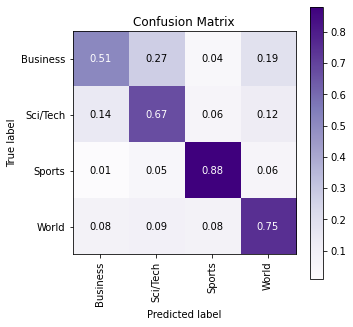

In [45]:
Y_actual, Y_preds = make_predictions(LSTM_classifier_layers, test_loader)
print_results(Y_actual, Y_preds, target_classes)

In [43]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
def pre_image(image, model, classes):
   with torch.no_grad():
      model.eval()  
      output = model(image)
      index = output.data.cpu().numpy().argmax()
      class_name = classes[index]
      return class_name

In [44]:
#for i, net in enumerate(nets):
#    print(f"Net {i} says it's {pre_image(image, net, db.classes)}")